In [1]:
!pip install python-graphblas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 17.7 MB/s eta 0:00:00


## Задача 1.

- Используя python-graphblas реализовать функцию PageRank с параметрами из лекции.

In [12]:
import graphblas as gb
import pandas as pd
import numpy as np

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread, from_networkx

import networkx as nx

In [4]:
def compute_pagerank(graph, alpha=0.8, max_iter=100, tolerance=1e-4):
    '''
    :param graph: Заданный граф
    :param alpha: трешхолд для телепорта
    :param max_iter: максимальное количество итераций
    :param tolerance: допустимая ошибка
    :return: Важность каждой вершины и затраченное количество итераций
    '''

    graph << graph.apply(unary.one)

    out_degree = graph.reduce_rowwise(monoid.plus).new()

    num_nodes = graph.nrows
    teleport_value = (1.0 - alpha) / num_nodes
    difference = 1

    temp_vector = Vector(dtypes.FP32, num_nodes)
    rank_vector = Vector(dtypes.FP32, num_nodes)
    weight_vector = Vector(dtypes.FP32, num_nodes)
    rank_vector[:] << 1.0 / num_nodes

    adjusted_degree = out_degree.dup(dtype="FP32")
    adjusted_degree(accum=binary.truediv)[:] << alpha

    for iteration in range(max_iter):
        if difference <= tolerance:
            break
        rank_vector, temp_vector = temp_vector, rank_vector
        weight_vector << temp_vector.ewise_mult(adjusted_degree, binary.truediv)
        rank_vector[:] << teleport_value
        rank_vector(binary.plus) << graph.T.mxv(weight_vector, semiring.plus_second)

        temp_vector(binary.minus)[:] << rank_vector
        temp_vector << temp_vector.apply(unary.abs)
        difference = temp_vector.reduce(monoid.plus).value

    return rank_vector, iteration

In [15]:
matrix_A = from_networkx(nx.erdos_renyi_graph(10, 0.2, directed=True), dtype='FP32') # Генерируем граф

In [16]:
result, iters = compute_pagerank(matrix_A)
result

"v_16"     nvals  size  dtype  format
gb.Vector     10    10   FP32    full
-------------------------------------
index         0         1         2         3         4        5         6  \
value  0.226655  0.121763  0.121763  0.055534  0.073337  0.04428  0.078245   

index         7         8         9  
value  0.067139  0.091048  0.120236

## Задача 2

- Провести экспериментальное исследование полученной реализации и сравнить её с реализацией из библиотеки NetworkX при различных значениях параметров на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection.

In [17]:
matrix_A_nx = gb.io.to_networkx(matrix_A)
nx.pagerank(matrix_A_nx, tol=1e-4)

{0: 0.23333438410880566,
 1: 0.12512193109020978,
 2: 0.12512193109020978,
 6: 0.07692267883567629,
 8: 0.08942308771894428,
 4: 0.07230350895835835,
 7: 0.06585929964083749,
 9: 0.11939170310129761,
 3: 0.05217202995062539,
 5: 0.040349445505035386}

**Видим что результаты почти не отличимы в реализациях!**

### Теперь сравним скорость на больших графах

In [18]:
import time
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm

In [19]:
def calculate_time(A):
    start_time = time.time()
    compute_pagerank(matrix_A)
    time_1 = time.time() - start_time

    matrix_A_nx = gb.io.to_networkx(A)
    start_time = time.time()
    nx.pagerank(matrix_A_nx, tol=1e-4)
    time_2 = time.time() - start_time

    return time_1, time_2

<ipython-input-25-4f8bd27b2fa0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for size in tqdm(np.arange(100, 1000, 25)):


  0%|          | 0/36 [00:00<?, ?it/s]

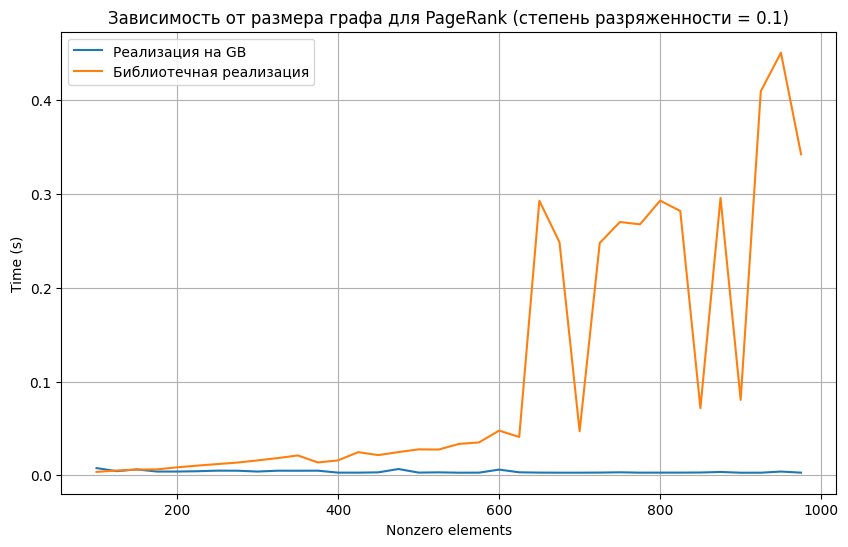

In [25]:
results_random = {}
for size in tqdm(np.arange(100, 1000, 25)):
    graph = from_networkx(nx.erdos_renyi_graph(size, 0.1, directed=True))
    times = calculate_time(graph)
    results_random[size] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='Реализация на GB')
ax.plot(num_vertices_list, time_2, label='Библиотечная реализация')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для PageRank (степень разряженности = 0.1)')
ax.legend()
ax.grid(True)
plt.show()

<ipython-input-26-2913a430cd2a>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for size in tqdm(np.arange(100, 1000, 50)):


  0%|          | 0/18 [00:00<?, ?it/s]

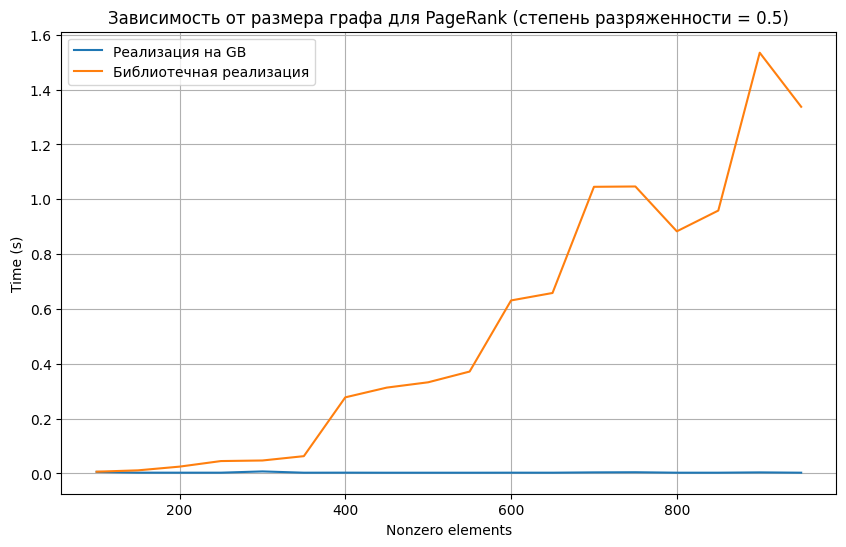

In [26]:
results_random = {}
for size in tqdm(np.arange(100, 1000, 50)):
    graph = from_networkx(nx.erdos_renyi_graph(size, 0.5, directed=True))
    times = calculate_time(graph)
    results_random[size] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='Реализация на GB')
ax.plot(num_vertices_list, time_2, label='Библиотечная реализация')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для PageRank (степень разряженности = 0.5)')
ax.legend()
ax.grid(True)
plt.show()

<ipython-input-27-76366a256c0b>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for size in tqdm(np.arange(100, 800, 50)):


  0%|          | 0/14 [00:00<?, ?it/s]

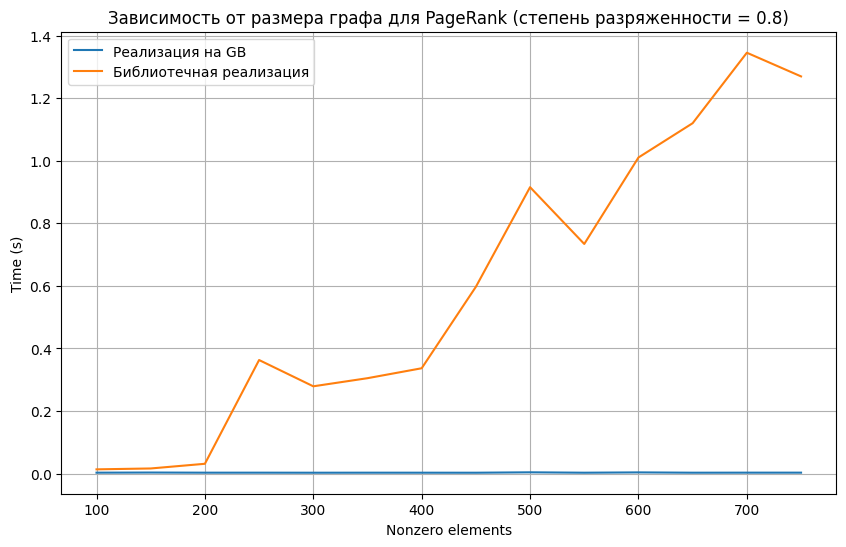

In [27]:
results_random = {}
for size in tqdm(np.arange(100, 800, 50)):
    graph = from_networkx(nx.erdos_renyi_graph(size, 0.8, directed=True))
    times = calculate_time(graph)
    results_random[size] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='Реализация на GB')
ax.plot(num_vertices_list, time_2, label='Библиотечная реализация')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для PageRank (степень разряженности = 0.8)')
ax.legend()
ax.grid(True)
plt.show()

## Выводы

- Был реализован PageRank на GM, произведено сравнение с библиотечной реализацией, результаты совпали.
- Также по результатам сравнения по скорости работы на больших графах. Чем больше размер графа, тем больше собственная реализация выигрывает у библиотечной реализации. С ростом разряженности собственная реализация выигрывает еще в несколько раз.